## Visualize EEG Data

In [3]:
# %pip install seaborn

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import mne
from matplotlib.widgets import Slider, Button, CheckButtons
import ipywidgets as widgets
from IPython.display import display, clear_output
import os
from scipy import signal as scipy_signal
from scipy.fft import fft, fftfreq
import seaborn as sns

class CHBMITVisualizer:
    """
    Comprehensive EEG visualizer for CHB-MIT Scalp dataset
    """
    
    def __init__(self, edf_path, seizure_path=None):
        """
        Initialize visualizer with EDF file and optional seizure annotations
        
        Parameters:
        -----------
        edf_path : str
            Path to .edf file
        seizure_path : str
            Path to .edf.seizures file (optional)
        """
        self.edf_path = edf_path
        self.seizure_path = seizure_path
        self.raw = None
        self.seizures = []
        self.load_data()
        
    def load_data(self):
        """Load EDF file and seizure annotations"""
        # Load EDF file using MNE
        self.raw = mne.io.read_raw_edf(self.edf_path, preload=True, verbose=False)
        print(f"Loaded EDF file: {self.edf_path}")
        print(f"Channels: {self.raw.ch_names}")
        print(f"Sampling rate: {self.raw.info['sfreq']} Hz")
        print(f"Duration: {self.raw.times[-1]:.2f} seconds")
        
        # Load seizure annotations if provided
        if self.seizure_path and os.path.exists(self.seizure_path):
            self.load_seizures()
    
    def load_seizures(self):
        """Parse seizure annotation file"""
        # Try different encodings
        encodings = ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252']
        lines = None
        
        for encoding in encodings:
            try:
                with open(self.seizure_path, 'r', encoding=encoding) as f:
                    lines = f.readlines()
                break
            except UnicodeDecodeError:
                continue
        
        if lines is None:
            # Try binary mode as last resort
            with open(self.seizure_path, 'rb') as f:
                content = f.read()
                lines = content.decode('latin-1', errors='ignore').split('\n')
        
        current_seizure = {}
        for line in lines:
            line = line.strip()
            if 'Seizure' in line and 'Start Time' in line:
                if 'seconds' in line:
                    start = int(line.split(':')[-1].strip().split()[0])
                    current_seizure['start'] = start
            elif 'Seizure' in line and 'End Time' in line:
                if 'seconds' in line:
                    end = int(line.split(':')[-1].strip().split()[0])
                    current_seizure['end'] = end
                    self.seizures.append(current_seizure.copy())
                    current_seizure = {}
        
        print(f"\nLoaded {len(self.seizures)} seizure(s):")
        for i, sz in enumerate(self.seizures):
            print(f"  Seizure {i+1}: {sz['start']}s - {sz['end']}s (duration: {sz['end']-sz['start']}s)")
    
    def plot_full_recording(self, channels=None, duration=None, scalings='auto', figsize=(15, 10)):
        """
        Plot the entire or partial recording using MNE's built-in plotting
        
        Parameters:
        -----------
        channels : list or None
            List of channel indices or names to plot. None = all channels
        duration : float or None
            Duration to plot in seconds. None = full recording
        scalings : dict or 'auto'
            Scaling for different channel types
        """
        if channels:
            picks = channels
        else:
            picks = 'all'
        
        if duration:
            self.raw.plot(duration=duration, n_channels=len(self.raw.ch_names), 
                         scalings=scalings, block=True, picks=picks)
        else:
            self.raw.plot(n_channels=len(self.raw.ch_names), 
                         scalings=scalings, block=True, picks=picks)
    
    def plot_time_segment(self, start_time=0, duration=10, channels=None, 
                          show_seizures=True, figsize=(15, 8)):
        """
        Plot a specific time segment with seizure annotations
        
        Parameters:
        -----------
        start_time : float
            Start time in seconds
        duration : float
            Duration to plot in seconds
        channels : list or None
            List of channel names to plot. None = all channels
        show_seizures : bool
            Whether to highlight seizure periods
        """
        if channels is None:
            channels = self.raw.ch_names
        
        # Get data
        start_sample = int(start_time * self.raw.info['sfreq'])
        end_sample = int((start_time + duration) * self.raw.info['sfreq'])
        data, times = self.raw.get_data(picks=channels, start=start_sample, 
                                        stop=end_sample, return_times=True)
        
        # Create figure
        fig, axes = plt.subplots(len(channels), 1, figsize=figsize, sharex=True)
        if len(channels) == 1:
            axes = [axes]
        
        # Plot each channel
        for i, (ch_data, ch_name) in enumerate(zip(data, channels)):
            axes[i].plot(times, ch_data * 1e6, 'g', linewidth=0.5)  # Convert to µV
            axes[i].set_ylabel(f'{ch_name}\n(µV)', fontsize=8)
            axes[i].grid(True, alpha=0.3)
            
            # Highlight seizures
            if show_seizures and self.seizures:
                for seizure in self.seizures:
                    if seizure['start'] < start_time + duration and seizure['end'] > start_time:
                        sz_start = max(seizure['start'], start_time)
                        sz_end = min(seizure['end'], start_time + duration)
                        axes[i].axvspan(sz_start, sz_end, alpha=0.3, color='red', 
                                       label='Seizure' if i == 0 else '')
        
        axes[-1].set_xlabel('Time (s)', fontsize=10)
        axes[0].set_title(f'EEG Recording: {start_time}s - {start_time+duration}s', fontsize=12)
        
        if show_seizures and self.seizures:
            axes[0].legend(loc='upper right')
        
        plt.tight_layout()
        plt.show()
    
    def plot_spectrogram(self, channel, start_time=0, duration=60, 
                        nperseg=256, figsize=(15, 6)):
        """
        Plot spectrogram for a specific channel
        
        Parameters:
        -----------
        channel : str or int
            Channel name or index
        start_time : float
            Start time in seconds
        duration : float
            Duration to plot in seconds
        nperseg : int
            Length of each segment for FFT
        """
        # Get data
        start_sample = int(start_time * self.raw.info['sfreq'])
        end_sample = int((start_time + duration) * self.raw.info['sfreq'])
        data, times = self.raw.get_data(picks=channel, start=start_sample, 
                                        stop=end_sample, return_times=True)
        
        # Compute spectrogram
        f, t, Sxx = scipy_signal.spectrogram(data[0], self.raw.info['sfreq'], 
                                            nperseg=nperseg)
        
        # Plot
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, 
                                        gridspec_kw={'height_ratios': [1, 2]})
        
        # Time domain
        ax1.plot(times, data[0] * 1e6, 'g', linewidth=0.5)
        ax1.set_ylabel('Amplitude (µV)')
        ax1.set_title(f'Channel: {self.raw.ch_names[channel] if isinstance(channel, int) else channel}')
        ax1.grid(True, alpha=0.3)
        
        # Highlight seizures
        if self.seizures:
            for seizure in self.seizures:
                if seizure['start'] < start_time + duration and seizure['end'] > start_time:
                    sz_start = max(seizure['start'], start_time)
                    sz_end = min(seizure['end'], start_time + duration)
                    ax1.axvspan(sz_start, sz_end, alpha=0.3, color='red')
        
        # Spectrogram
        im = ax2.pcolormesh(t + start_time, f, 10 * np.log10(Sxx), 
                           shading='gouraud', cmap='viridis')
        ax2.set_ylabel('Frequency (Hz)')
        ax2.set_xlabel('Time (s)')
        ax2.set_ylim([0, 50])  # Focus on 0-50 Hz
        
        # Highlight seizures
        if self.seizures:
            for seizure in self.seizures:
                if seizure['start'] < start_time + duration and seizure['end'] > start_time:
                    sz_start = max(seizure['start'], start_time)
                    sz_end = min(seizure['end'], start_time + duration)
                    ax2.axvspan(sz_start, sz_end, alpha=0.3, color='red')
        
        plt.colorbar(im, ax=ax2, label='Power (dB)')
        plt.tight_layout()
        plt.show()
    
    def plot_power_spectrum(self, channels=None, start_time=0, duration=10, 
                           max_freq=50, figsize=(12, 6)):
        """
        Plot power spectral density for selected channels
        
        Parameters:
        -----------
        channels : list or None
            List of channel names. None = all channels
        start_time : float
            Start time in seconds
        duration : float
            Duration to analyze in seconds
        max_freq : float
            Maximum frequency to display
        """
        if channels is None:
            channels = self.raw.ch_names[:5]  # First 5 channels by default
        
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        
        # Get data
        start_sample = int(start_time * self.raw.info['sfreq'])
        end_sample = int((start_time + duration) * self.raw.info['sfreq'])
        
        for ch in channels:
            data = self.raw.get_data(picks=ch, start=start_sample, stop=end_sample)[0]
            
            # Compute PSD
            freqs, psd = scipy_signal.welch(data, self.raw.info['sfreq'], 
                                           nperseg=min(256, len(data)))
            
            # Plot linear scale
            mask = freqs <= max_freq
            axes[0].plot(freqs[mask], psd[mask], label=ch, alpha=0.7)
            
            # Plot log scale
            axes[1].semilogy(freqs[mask], psd[mask], label=ch, alpha=0.7)
        
        axes[0].set_xlabel('Frequency (Hz)')
        axes[0].set_ylabel('PSD (V²/Hz)')
        axes[0].set_title('Power Spectral Density')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        axes[1].set_xlabel('Frequency (Hz)')
        axes[1].set_ylabel('PSD (V²/Hz) [log scale]')
        axes[1].set_title('Power Spectral Density (Log Scale)')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_channel_correlation(self, start_time=0, duration=60, figsize=(12, 10)):
        """
        Plot correlation matrix between all channels
        
        Parameters:
        -----------
        start_time : float
            Start time in seconds
        duration : float
            Duration to analyze in seconds
        """
        # Get data
        start_sample = int(start_time * self.raw.info['sfreq'])
        end_sample = int((start_time + duration) * self.raw.info['sfreq'])
        data = self.raw.get_data(start=start_sample, stop=end_sample)
        
        # Compute correlation matrix
        corr_matrix = np.corrcoef(data)
        
        # Plot
        fig, ax = plt.subplots(figsize=figsize)
        im = ax.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
        
        # Set ticks
        ax.set_xticks(range(len(self.raw.ch_names)))
        ax.set_yticks(range(len(self.raw.ch_names)))
        ax.set_xticklabels(self.raw.ch_names, rotation=90, fontsize=8)
        ax.set_yticklabels(self.raw.ch_names, fontsize=8)
        
        plt.colorbar(im, ax=ax, label='Correlation')
        ax.set_title(f'Channel Correlation Matrix ({start_time}s - {start_time+duration}s)')
        plt.tight_layout()
        plt.show()
    
    def plot_frequency_bands(self, channel, start_time=0, duration=60, figsize=(15, 8)):
        """
        Plot EEG frequency bands (Delta, Theta, Alpha, Beta, Gamma)
        
        Parameters:
        -----------
        channel : str or int
            Channel name or index
        start_time : float
            Start time in seconds
        duration : float
            Duration to analyze in seconds
        """
        # Define frequency bands
        bands = {
            'Delta (0.5-4 Hz)': (0.5, 4),
            'Theta (4-8 Hz)': (4, 8),
            'Alpha (8-13 Hz)': (8, 13),
            'Beta (13-30 Hz)': (13, 30),
            'Gamma (30-50 Hz)': (30, 50)
        }
        
        # Get data
        start_sample = int(start_time * self.raw.info['sfreq'])
        end_sample = int((start_time + duration) * self.raw.info['sfreq'])
        data, times = self.raw.get_data(picks=channel, start=start_sample, 
                                        stop=end_sample, return_times=True)
        
        # Create figure
        fig, axes = plt.subplots(len(bands) + 1, 1, figsize=figsize, sharex=True)
        
        # Plot original signal
        axes[0].plot(times, data[0] * 1e6, 'k', linewidth=0.5)
        axes[0].set_ylabel('Original\n(µV)', fontsize=9)
        axes[0].set_title(f'Frequency Band Decomposition - Channel: {self.raw.ch_names[channel] if isinstance(channel, int) else channel}')
        axes[0].grid(True, alpha=0.3)
        
        # Filter and plot each band
        for i, (band_name, (low, high)) in enumerate(bands.items()):
            filtered = mne.filter.filter_data(data[0], self.raw.info['sfreq'], 
                                             low, high, verbose=False)
            axes[i+1].plot(times, filtered * 1e6, linewidth=0.5)
            axes[i+1].set_ylabel(f'{band_name}\n(µV)', fontsize=9)
            axes[i+1].grid(True, alpha=0.3)
        
        # Highlight seizures
        if self.seizures:
            for ax in axes:
                for seizure in self.seizures:
                    if seizure['start'] < start_time + duration and seizure['end'] > start_time:
                        sz_start = max(seizure['start'], start_time)
                        sz_end = min(seizure['end'], start_time + duration)
                        ax.axvspan(sz_start, sz_end, alpha=0.2, color='red')
        
        axes[-1].set_xlabel('Time (s)')
        plt.tight_layout()
        plt.show()
    
    def plot_band_power_over_time(self, channel, start_time=0, duration=300, 
                                  window=4, figsize=(15, 8)):
        """
        Plot power in different frequency bands over time
        
        Parameters:
        -----------
        channel : str or int
            Channel name or index
        start_time : float
            Start time in seconds
        duration : float
            Duration to analyze in seconds
        window : float
            Window size in seconds for power calculation
        """
        bands = {
            'Delta': (0.5, 4),
            'Theta': (4, 8),
            'Alpha': (8, 13),
            'Beta': (13, 30),
            'Gamma': (30, 50)
        }
        
        # Get data
        start_sample = int(start_time * self.raw.info['sfreq'])
        end_sample = int((start_time + duration) * self.raw.info['sfreq'])
        data = self.raw.get_data(picks=channel, start=start_sample, stop=end_sample)[0]
        
        # Calculate window parameters
        window_samples = int(window * self.raw.info['sfreq'])
        hop_samples = window_samples // 2
        n_windows = (len(data) - window_samples) // hop_samples + 1
        
        # Compute band power over time
        band_powers = {band: np.zeros(n_windows) for band in bands}
        time_points = np.zeros(n_windows)
        
        for i in range(n_windows):
            start_idx = i * hop_samples
            end_idx = start_idx + window_samples
            segment = data[start_idx:end_idx]
            time_points[i] = start_time + (start_idx + window_samples/2) / self.raw.info['sfreq']
            
            # Compute PSD for this window
            freqs, psd = scipy_signal.welch(segment, self.raw.info['sfreq'], nperseg=window_samples)
            
            # Calculate band power
            for band, (low, high) in bands.items():
                mask = (freqs >= low) & (freqs <= high)
                band_powers[band][i] = np.trapz(psd[mask], freqs[mask])
        
        # Plot
        fig, axes = plt.subplots(len(bands), 1, figsize=figsize, sharex=True)
        
        colors = ['blue', 'green', 'orange', 'red', 'purple']
        for i, ((band, power), color) in enumerate(zip(band_powers.items(), colors)):
            axes[i].plot(time_points, power, color=color, linewidth=1.5)
            axes[i].set_ylabel(f'{band}\nPower', fontsize=9)
            axes[i].grid(True, alpha=0.3)
            axes[i].fill_between(time_points, 0, power, alpha=0.3, color=color)
            
            # Highlight seizures
            if self.seizures:
                for seizure in self.seizures:
                    if seizure['start'] < start_time + duration and seizure['end'] > start_time:
                        sz_start = max(seizure['start'], start_time)
                        sz_end = min(seizure['end'], start_time + duration)
                        axes[i].axvspan(sz_start, sz_end, alpha=0.3, color='red')
        
        axes[0].set_title(f'Frequency Band Power Over Time - Channel: {self.raw.ch_names[channel] if isinstance(channel, int) else channel}')
        axes[-1].set_xlabel('Time (s)')
        plt.tight_layout()
        plt.show()
    
    def interactive_viewer(self):
        """
        Create an interactive widget-based viewer for Jupyter notebooks
        """
        # Create widgets
        time_slider = widgets.FloatSlider(
            value=0,
            min=0,
            max=self.raw.times[-1] - 10,
            step=1,
            description='Start Time:',
            continuous_update=False
        )
        
        duration_slider = widgets.FloatSlider(
            value=10,
            min=1,
            max=60,
            step=1,
            description='Duration:',
            continuous_update=False
        )
        
        channel_select = widgets.SelectMultiple(
            options=self.raw.ch_names,
            value=[self.raw.ch_names[0]],
            description='Channels:',
            disabled=False
        )
        
        plot_button = widgets.Button(description='Update Plot')
        
        output = widgets.Output()
        
        def on_button_click(b):
            with output:
                clear_output(wait=True)
                selected_channels = list(channel_select.value)
                if selected_channels:
                    self.plot_time_segment(
                        start_time=time_slider.value,
                        duration=duration_slider.value,
                        channels=selected_channels
                    )
        
        plot_button.on_click(on_button_click)
        
        # Display widgets
        display(widgets.VBox([
            widgets.HBox([time_slider, duration_slider]),
            channel_select,
            plot_button,
            output
        ]))
        
        # Initial plot
        with output:
            self.plot_time_segment(
                start_time=0,
                duration=10,
                channels=[self.raw.ch_names[0]]
            )
    
    def generate_report(self, output_dir='eeg_report'):
        """
        Generate a comprehensive HTML report with all visualizations
        
        Parameters:
        -----------
        output_dir : str
            Directory to save the report
        """
        os.makedirs(output_dir, exist_ok=True)
        
        print("Generating comprehensive EEG analysis report...")
        
        # 1. Basic info
        print("1. Recording information...")
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.axis('off')
        info_text = f"""
        Recording Information:
        ----------------------
        File: {os.path.basename(self.edf_path)}
        Duration: {self.raw.times[-1]:.2f} seconds
        Sampling Rate: {self.raw.info['sfreq']} Hz
        Number of Channels: {len(self.raw.ch_names)}
        Channels: {', '.join(self.raw.ch_names)}
        
        Seizure Information:
        --------------------
        Number of Seizures: {len(self.seizures)}
        """
        
        for i, sz in enumerate(self.seizures):
            info_text += f"\nSeizure {i+1}: {sz['start']}s - {sz['end']}s (duration: {sz['end']-sz['start']}s)"
        
        ax.text(0.1, 0.9, info_text, transform=ax.transAxes, 
               fontsize=12, verticalalignment='top', family='monospace')
        plt.savefig(f'{output_dir}/01_info.png', bbox_inches='tight', dpi=100)
        plt.close()
        
        # 2. Full time series (first 60 seconds)
        print("2. Time series visualization...")
        self.plot_time_segment(start_time=0, duration=60, 
                              channels=self.raw.ch_names[:10])
        plt.savefig(f'{output_dir}/02_timeseries.png', bbox_inches='tight', dpi=100)
        plt.close()
        
        # 3. Spectrogram
        print("3. Spectrogram analysis...")
        self.plot_spectrogram(self.raw.ch_names[0], start_time=0, duration=60)
        plt.savefig(f'{output_dir}/03_spectrogram.png', bbox_inches='tight', dpi=100)
        plt.close()
        
        # 4. Power spectrum
        print("4. Power spectrum analysis...")
        self.plot_power_spectrum(channels=self.raw.ch_names[:5])
        plt.savefig(f'{output_dir}/04_power_spectrum.png', bbox_inches='tight', dpi=100)
        plt.close()
        
        # 5. Frequency bands
        print("5. Frequency band decomposition...")
        self.plot_frequency_bands(self.raw.ch_names[0], duration=60)
        plt.savefig(f'{output_dir}/05_frequency_bands.png', bbox_inches='tight', dpi=100)
        plt.close()
        
        # 6. Band power over time
        print("6. Band power evolution...")
        self.plot_band_power_over_time(self.raw.ch_names[0], duration=min(300, self.raw.times[-1]))
        plt.savefig(f'{output_dir}/06_band_power.png', bbox_inches='tight', dpi=100)
        plt.close()
        
        # 7. Correlation matrix
        print("7. Channel correlation analysis...")
        self.plot_channel_correlation(duration=60)
        plt.savefig(f'{output_dir}/07_correlation.png', bbox_inches='tight', dpi=100)
        plt.close()
        
        print(f"\nReport generated successfully in '{output_dir}' directory!")
        print("Images saved:")
        for f in sorted(os.listdir(output_dir)):
            print(f"  - {f}")

# Example usage:
"""
# Initialize visualizer
viz = CHBMITVisualizer(
    edf_path='path/to/chb01_03.edf',
    seizure_path='path/to/chb01_03.edf.seizures'  # Optional
)

# 1. Plot a time segment
viz.plot_time_segment(start_time=0, duration=10, channels=['FP1-F7', 'F7-T7'])

# 2. Plot spectrogram
viz.plot_spectrogram(channel='FP1-F7', start_time=0, duration=60)

# 3. Plot power spectrum
viz.plot_power_spectrum(channels=['FP1-F7', 'F7-T7', 'T7-P7'])

# 4. Plot frequency bands
viz.plot_frequency_bands(channel='FP1-F7', start_time=0, duration=60)

# 5. Plot band power over time
viz.plot_band_power_over_time(channel='FP1-F7', duration=300)

# 6. Plot channel correlations
viz.plot_channel_correlation(start_time=0, duration=60)

# 7. Interactive viewer (Jupyter only)
viz.interactive_viewer()

# 8. Generate comprehensive report
viz.generate_report(output_dir='my_eeg_report')
"""

"\n# Initialize visualizer\nviz = CHBMITVisualizer(\n    edf_path='path/to/chb01_03.edf',\n    seizure_path='path/to/chb01_03.edf.seizures'  # Optional\n)\n\n# 1. Plot a time segment\nviz.plot_time_segment(start_time=0, duration=10, channels=['FP1-F7', 'F7-T7'])\n\n# 2. Plot spectrogram\nviz.plot_spectrogram(channel='FP1-F7', start_time=0, duration=60)\n\n# 3. Plot power spectrum\nviz.plot_power_spectrum(channels=['FP1-F7', 'F7-T7', 'T7-P7'])\n\n# 4. Plot frequency bands\nviz.plot_frequency_bands(channel='FP1-F7', start_time=0, duration=60)\n\n# 5. Plot band power over time\nviz.plot_band_power_over_time(channel='FP1-F7', duration=300)\n\n# 6. Plot channel correlations\nviz.plot_channel_correlation(start_time=0, duration=60)\n\n# 7. Interactive viewer (Jupyter only)\nviz.interactive_viewer()\n\n# 8. Generate comprehensive report\nviz.generate_report(output_dir='my_eeg_report')\n"

In [7]:
# Initialize visualizer
viz = CHBMITVisualizer(
    edf_path='./eeg_files/chb18_30.edf',
    seizure_path='./eeg_files/chb18_32.edf.seizures'  # Optional
)

Loaded EDF file: ./eeg_files/chb18_30.edf
Channels: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', '.-0', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', '.-1', 'FZ-CZ', 'CZ-PZ', '.-2', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', '.-3', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', '.-4', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8-1']
Sampling rate: 256.0 Hz
Duration: 3600.00 seconds

Loaded 0 seizure(s):


/var/folders/jm/ghwgvclx7g3d68lp4w8vhpp40000gn/T/ipykernel_36730/468686493.py:37: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '.'}. Applying running numbers for duplicates.
  self.raw = mne.io.read_raw_edf(self.edf_path, preload=True, verbose=False)


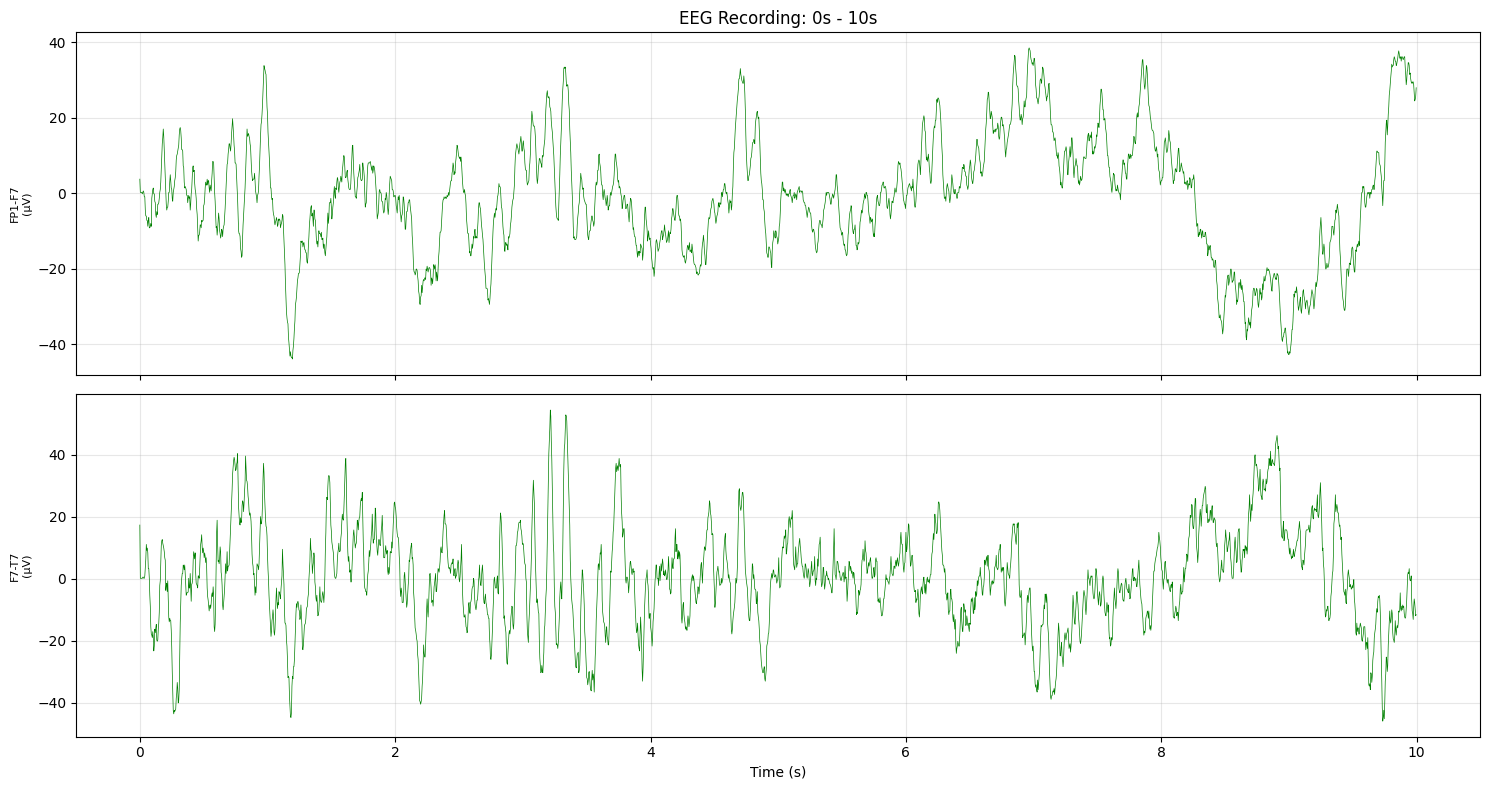

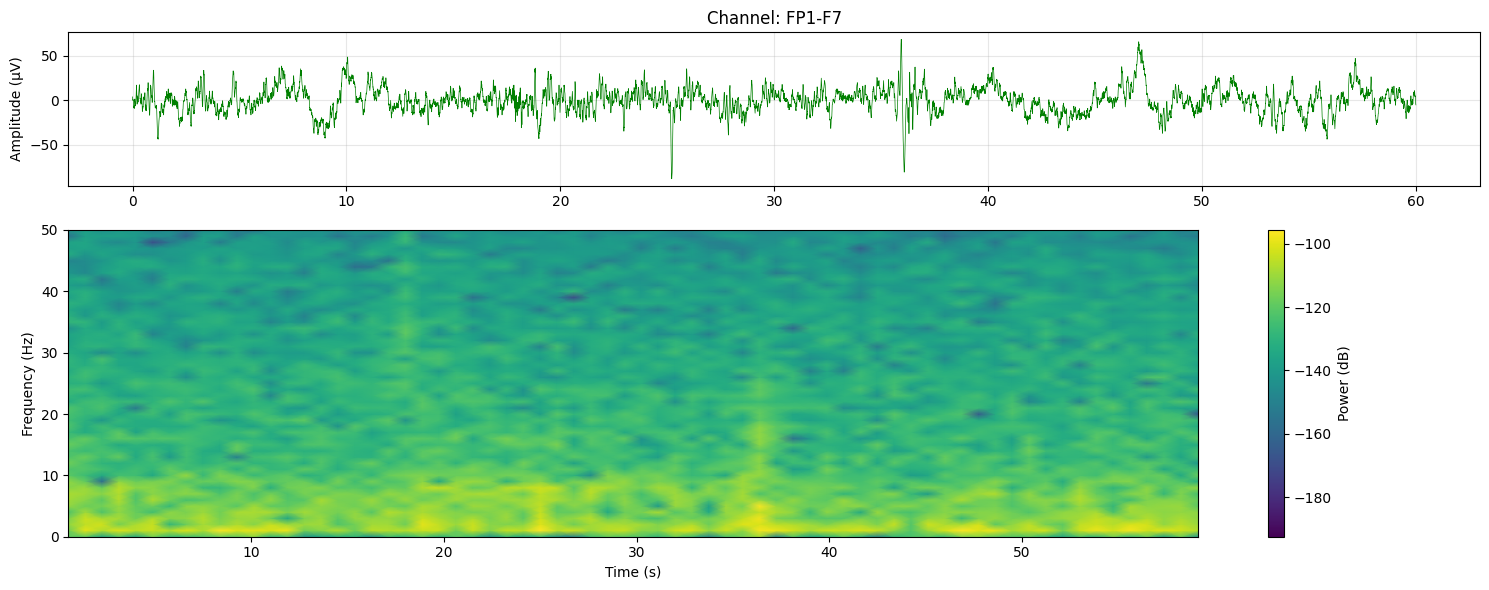

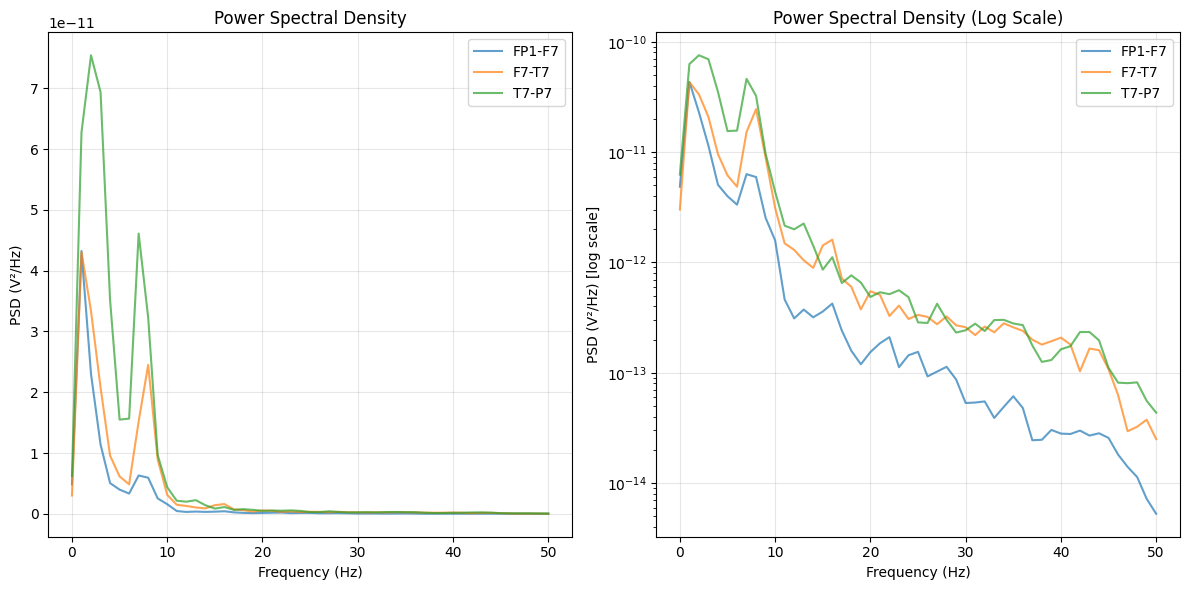

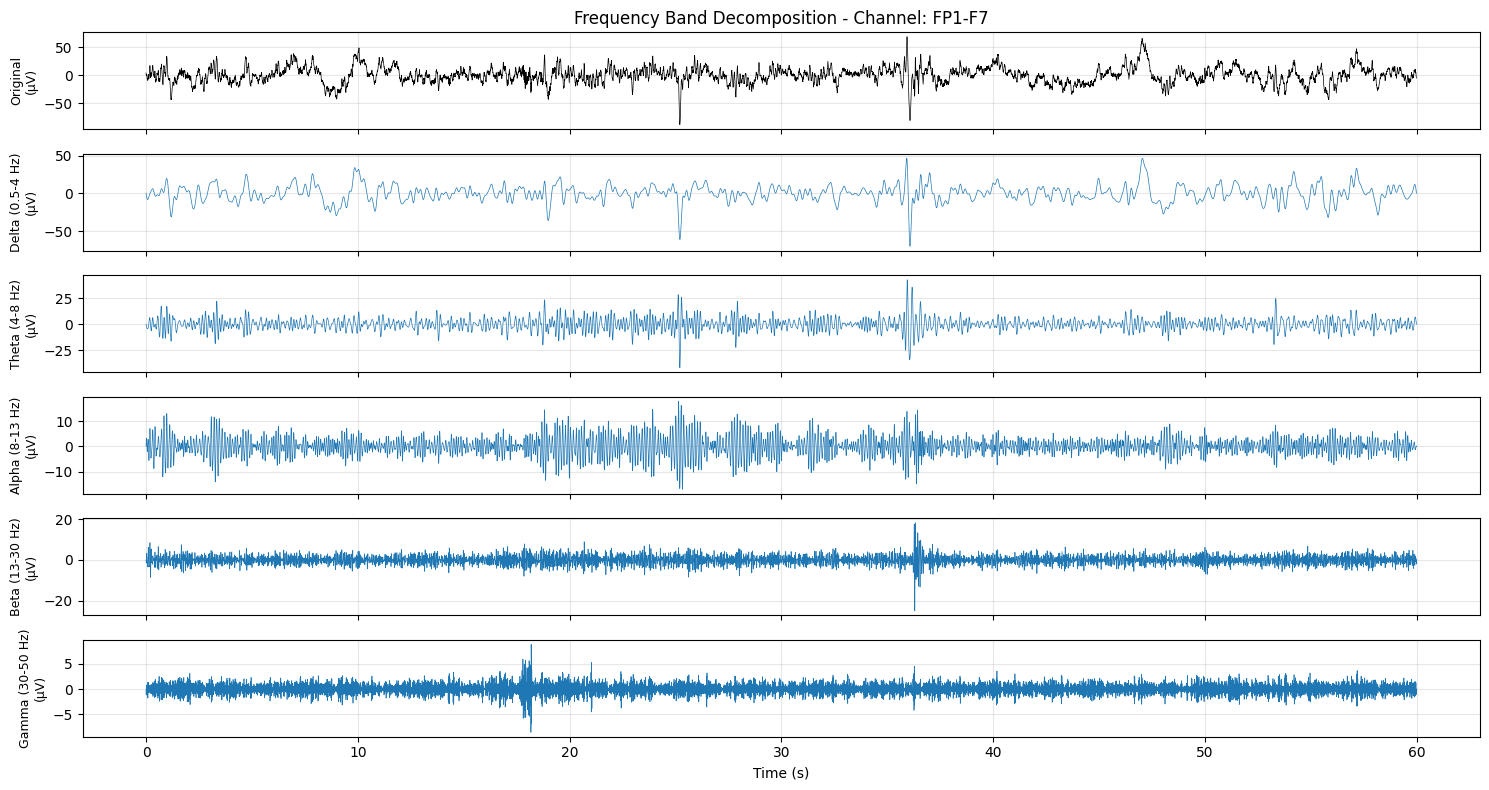

/var/folders/jm/ghwgvclx7g3d68lp4w8vhpp40000gn/T/ipykernel_36730/468686493.py:423: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_powers[band][i] = np.trapz(psd[mask], freqs[mask])


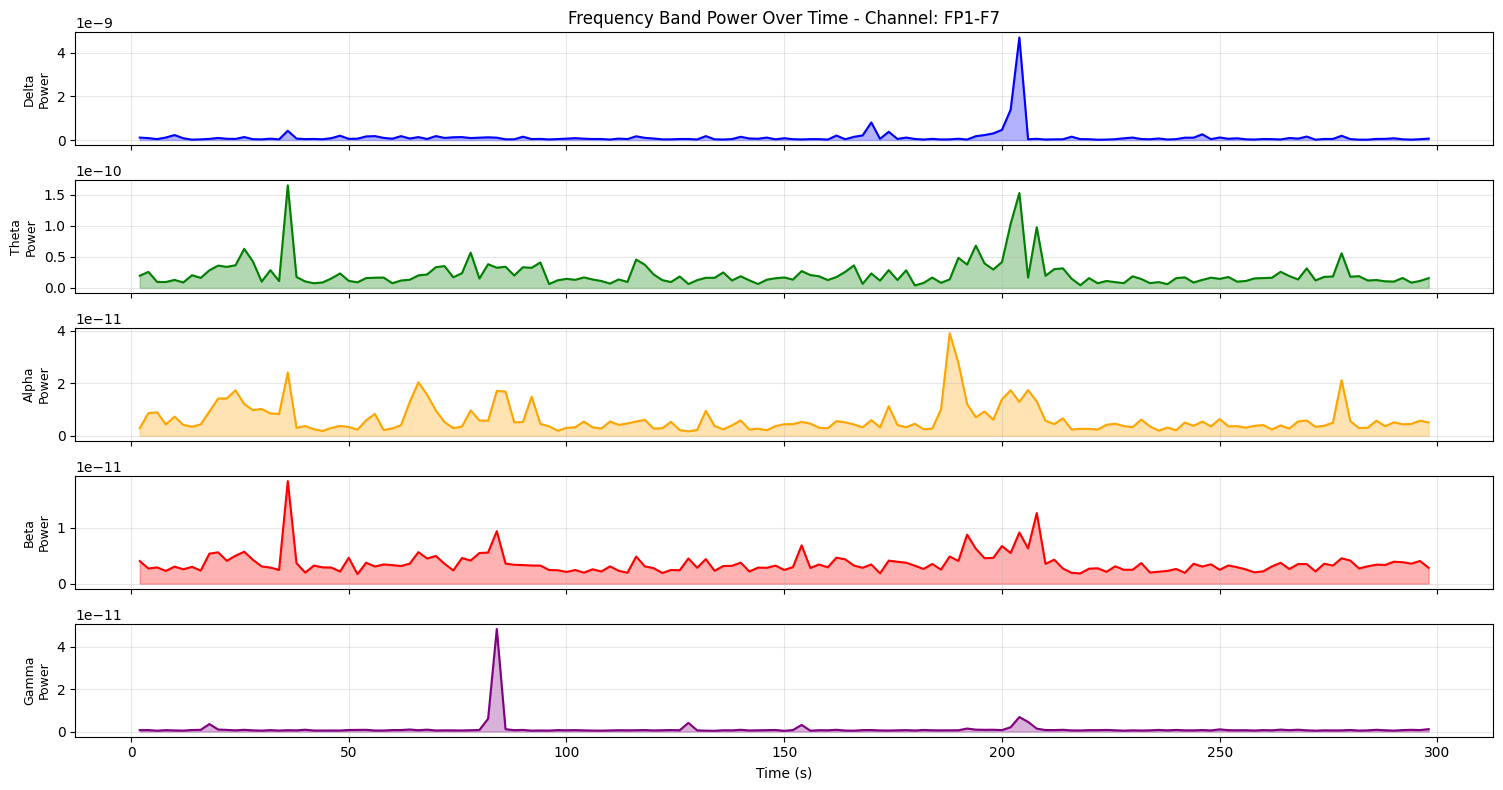

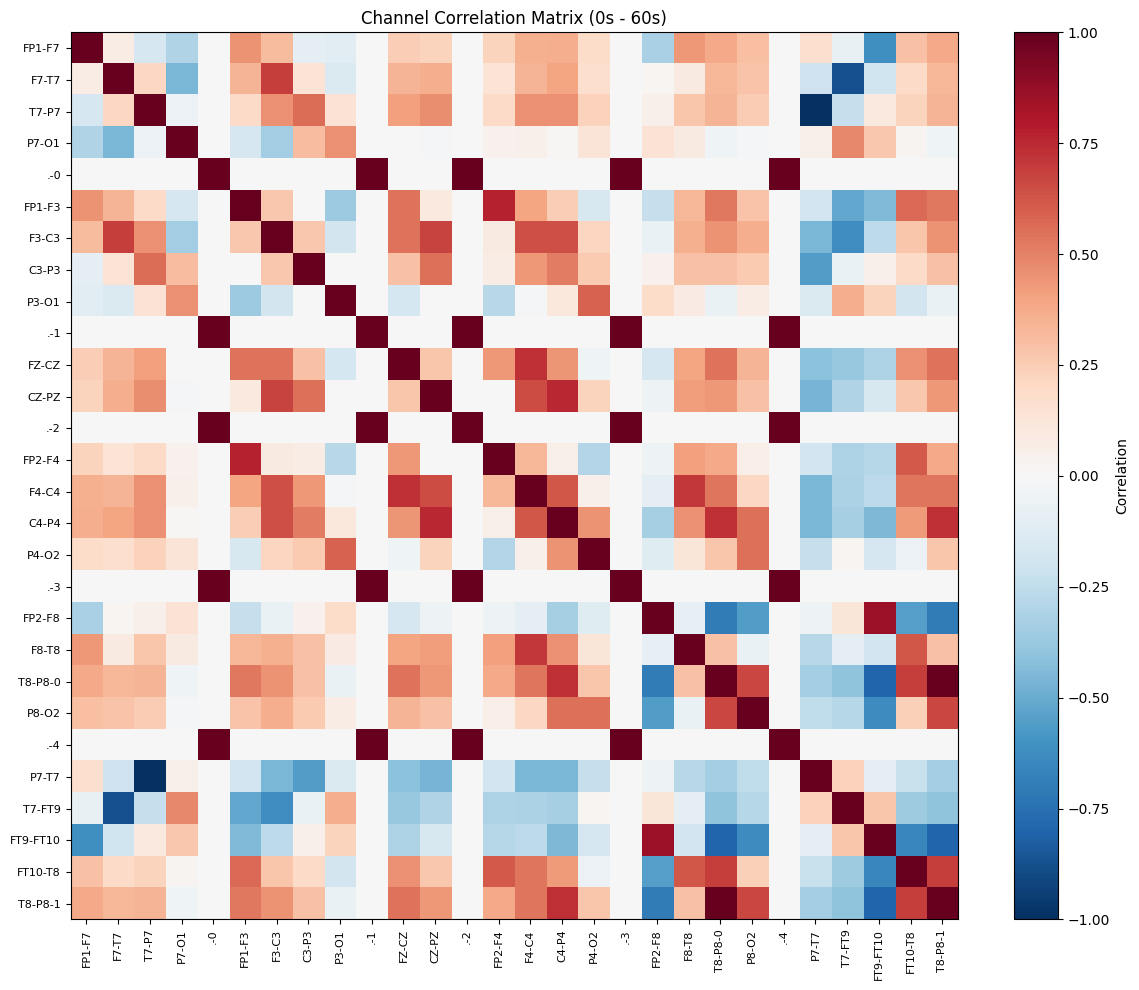

Generating comprehensive EEG analysis report...
1. Recording information...
2. Time series visualization...


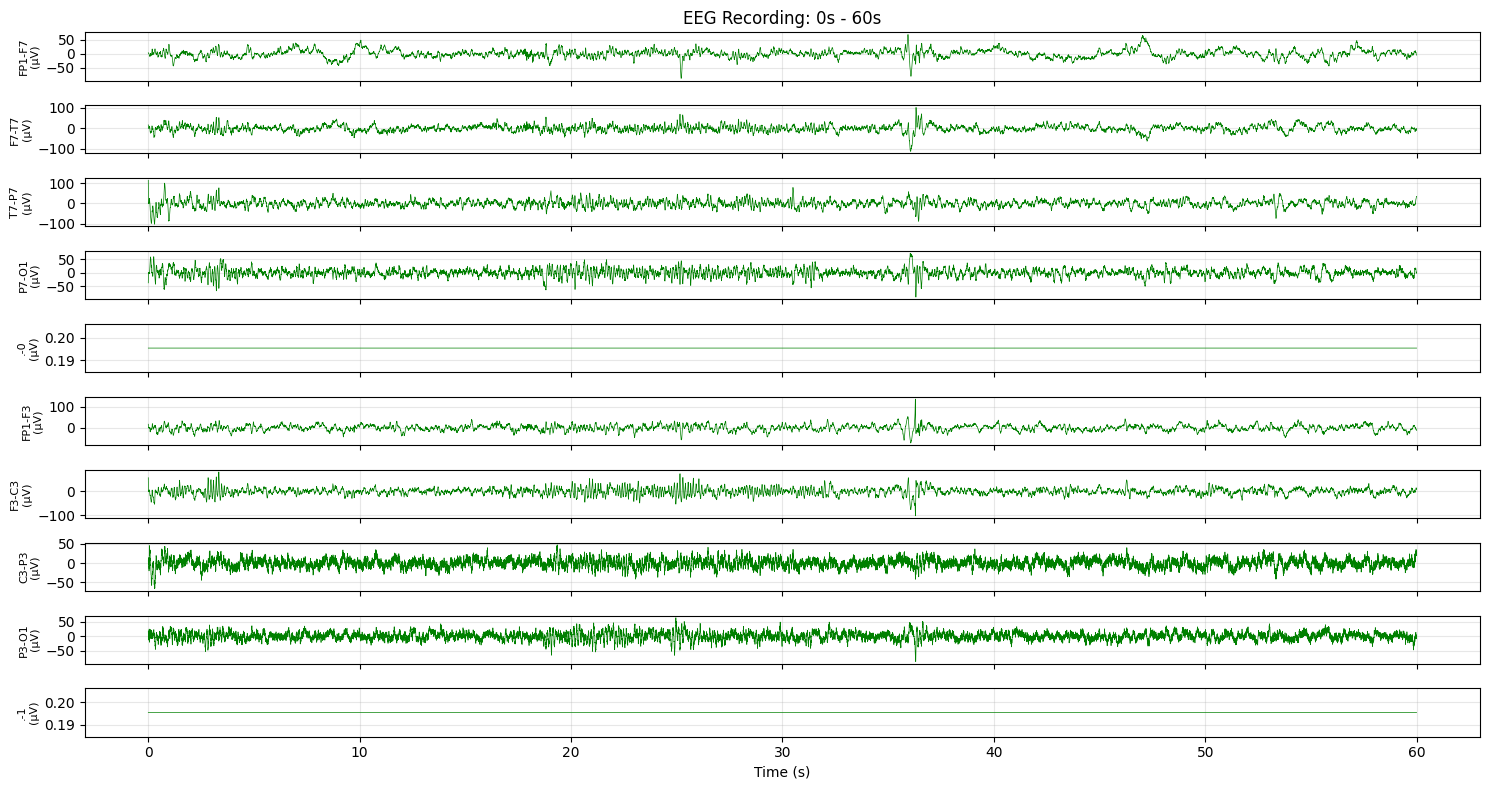

3. Spectrogram analysis...


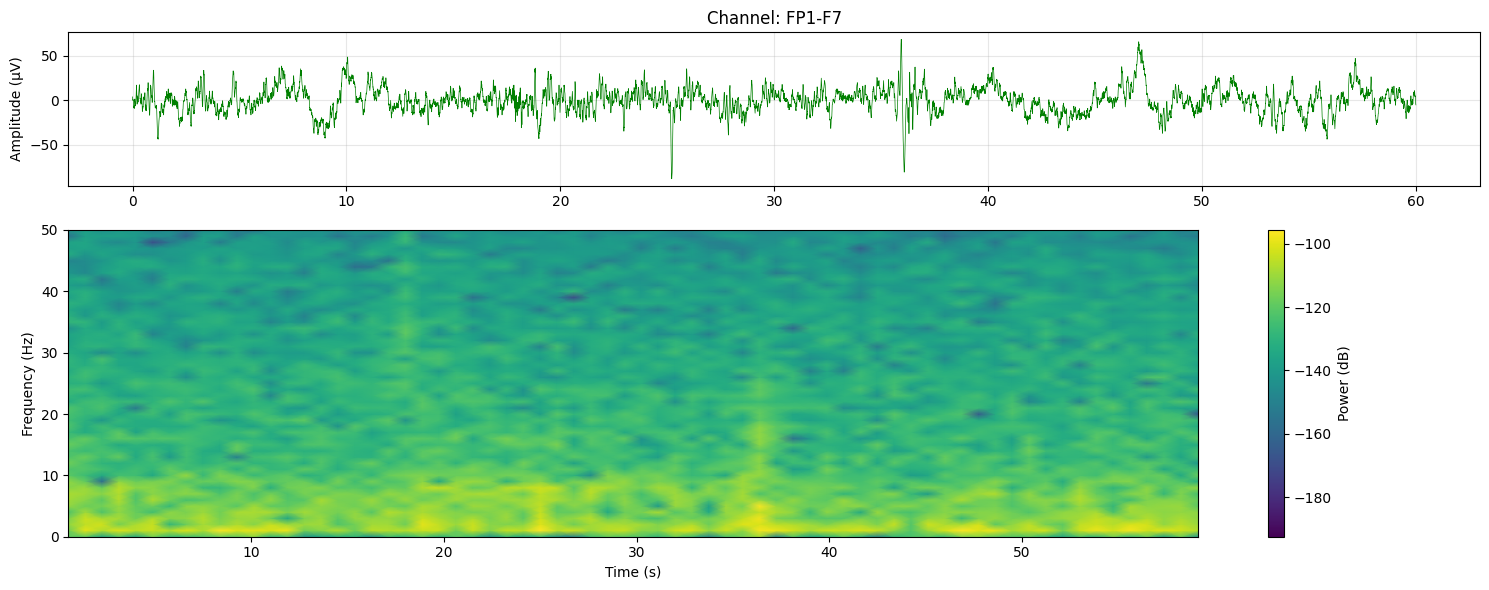

4. Power spectrum analysis...


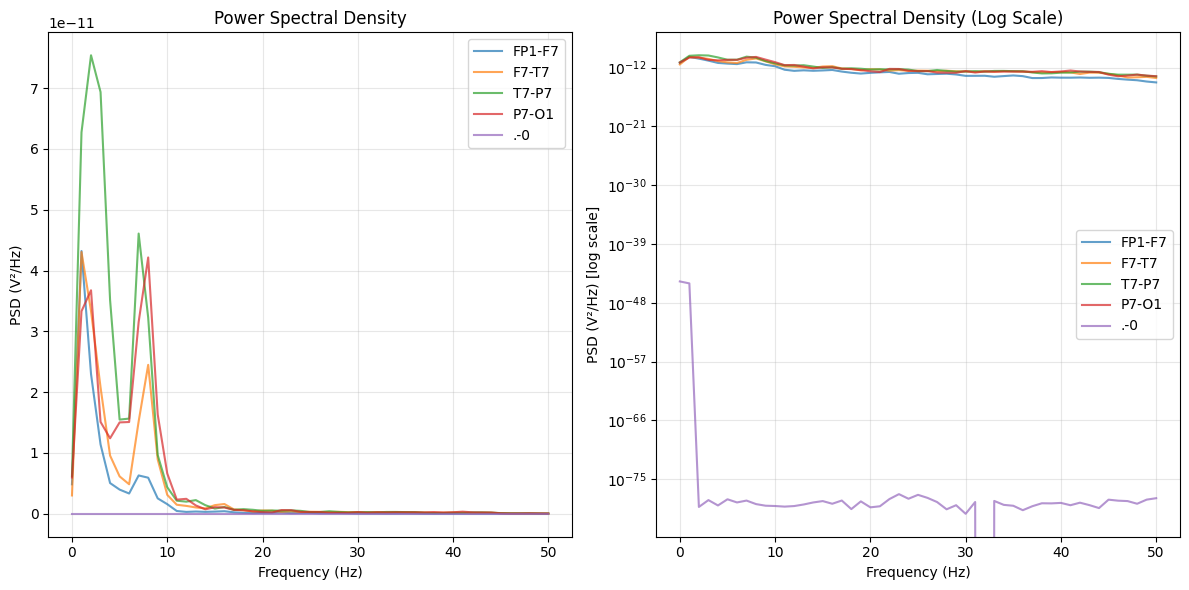

5. Frequency band decomposition...


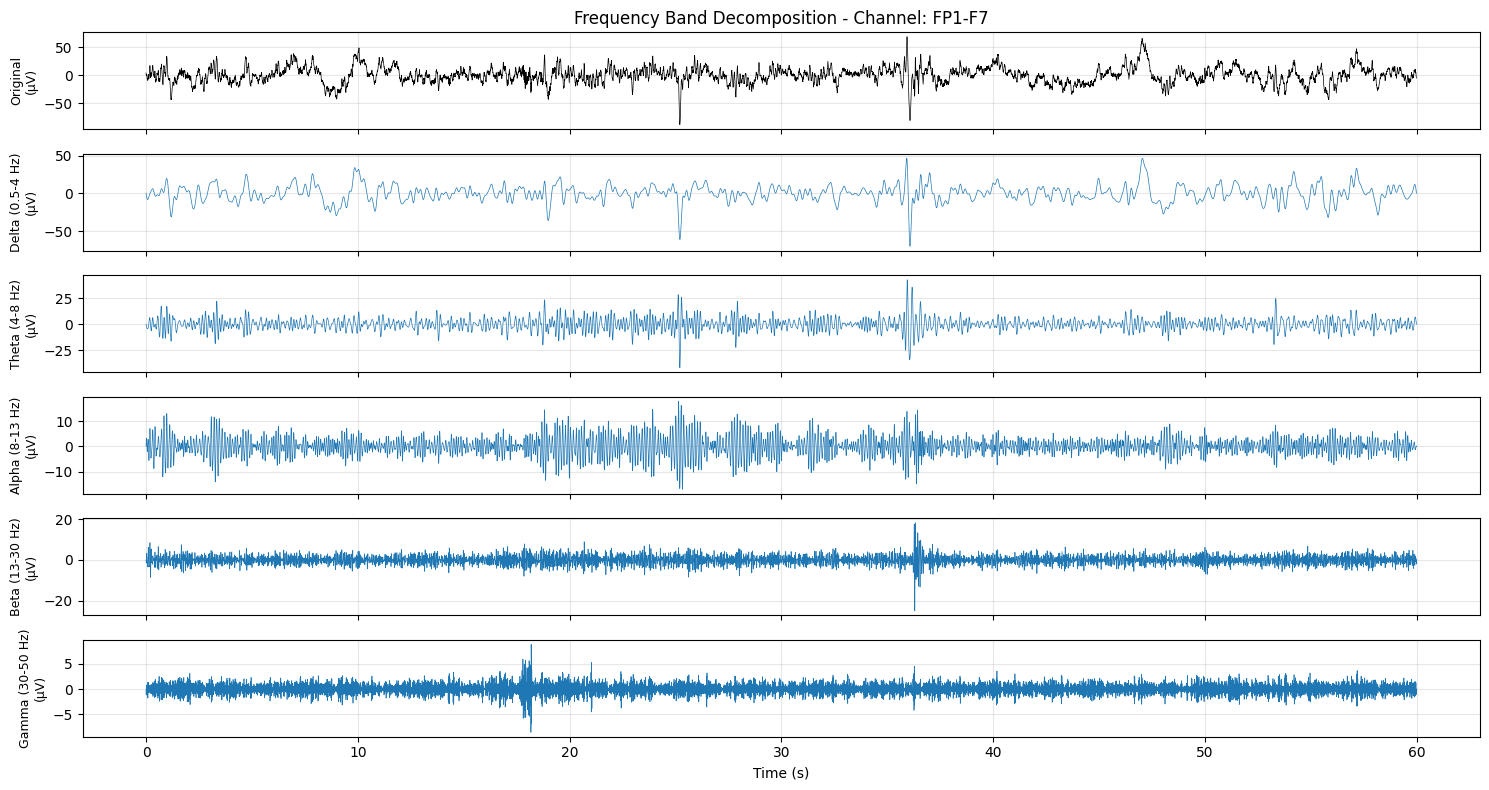

6. Band power evolution...


/var/folders/jm/ghwgvclx7g3d68lp4w8vhpp40000gn/T/ipykernel_36730/468686493.py:423: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_powers[band][i] = np.trapz(psd[mask], freqs[mask])


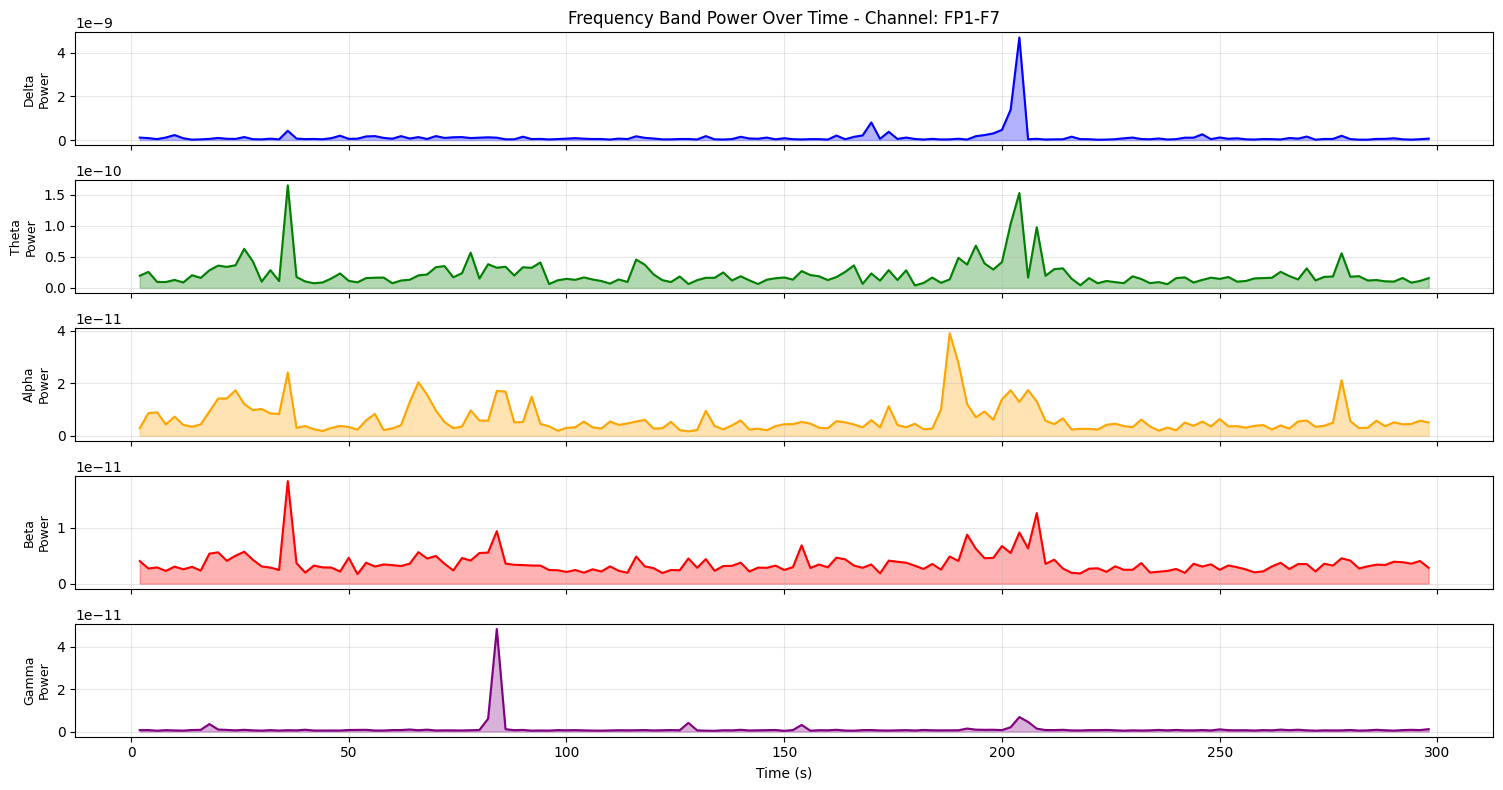

7. Channel correlation analysis...


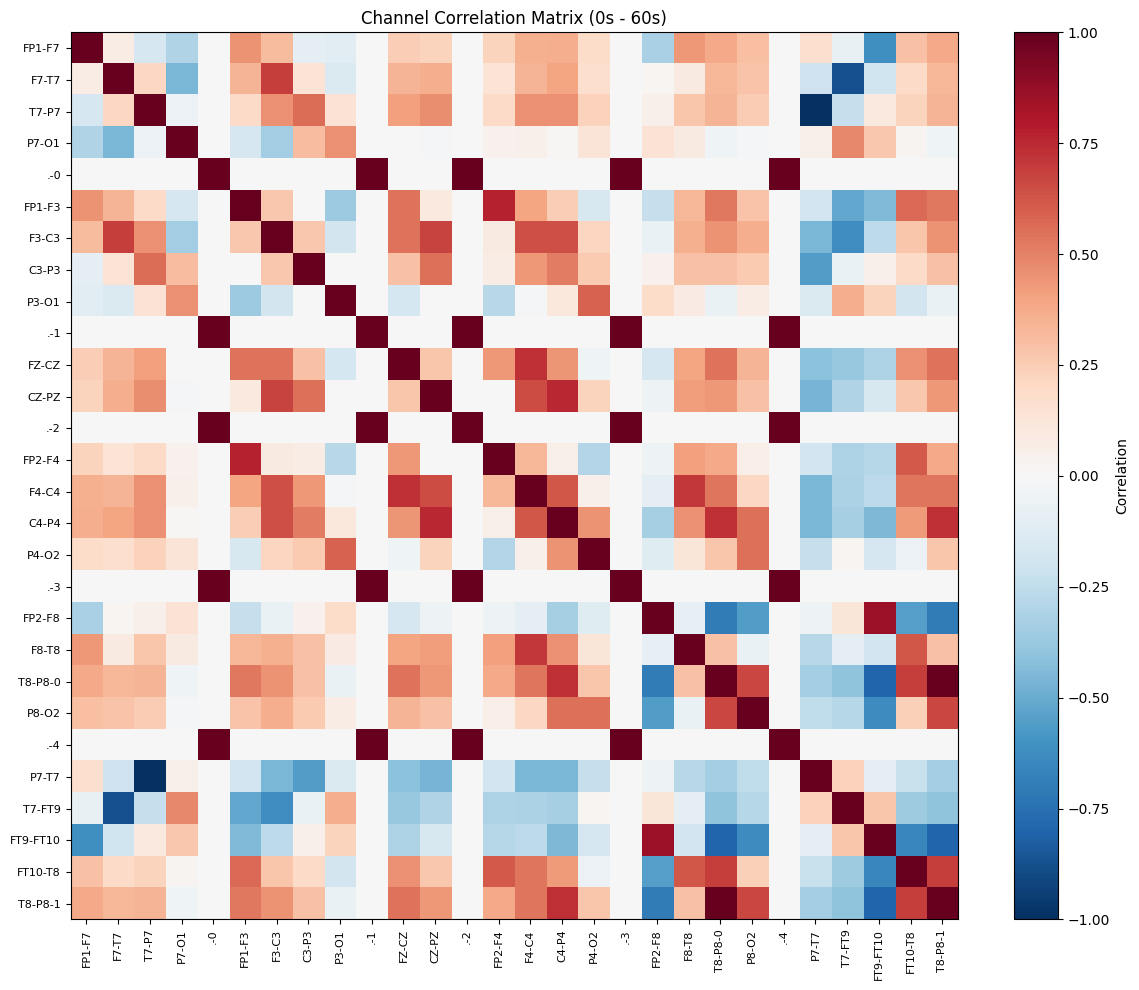


Report generated successfully in 'my_eeg_report' directory!
Images saved:
  - 01_info.png
  - 02_timeseries.png
  - 03_spectrogram.png
  - 04_power_spectrum.png
  - 05_frequency_bands.png
  - 06_band_power.png
  - 07_correlation.png


In [8]:
# 1. Plot a time segment
viz.plot_time_segment(start_time=0, duration=10, channels=['FP1-F7', 'F7-T7'])

# 2. Plot spectrogram
viz.plot_spectrogram(channel='FP1-F7', start_time=0, duration=60)

# 3. Plot power spectrum
viz.plot_power_spectrum(channels=['FP1-F7', 'F7-T7', 'T7-P7'])

# 4. Plot frequency bands
viz.plot_frequency_bands(channel='FP1-F7', start_time=0, duration=60)

# 5. Plot band power over time
viz.plot_band_power_over_time(channel='FP1-F7', duration=300)

# 6. Plot channel correlations
viz.plot_channel_correlation(start_time=0, duration=60)

# 8. Generate comprehensive report
viz.generate_report(output_dir='my_eeg_report')